## 📚 Importing Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import os
import ray
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from transformers import BertTokenizer
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import warnings
warnings.filterwarnings("ignore")


c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\_private\parameter.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 🛠️ Setup

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-08-17 01:09:11,730	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.18
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'object_store_memory': 278190489.0,
 'memory': 556380980.0,
 'node:127.0.0.1': 1.0,
 'GPU': 1.0,
 'CPU': 12.0,
 'node:__internal_head__': 1.0}

## 📥 Data Ingestion

In [4]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [5]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

## ✂️ Data Splitting

In [6]:
# Split dataset
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=0.2, random_state=42)


In [7]:
# Train value counts
train_df.tag.value_counts()


tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [8]:
# Validation (adjusted) value counts
val_df.tag.value_counts()* int((1-0.2) / 0.2)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 📊 Exploratory Data Analysis (EDA)

In [9]:
# check most common tags
df.tag.value_counts()


tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [10]:
# Check nulls
df.isnull().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

In [11]:
# Check duplicates
df.duplicated().sum()

0

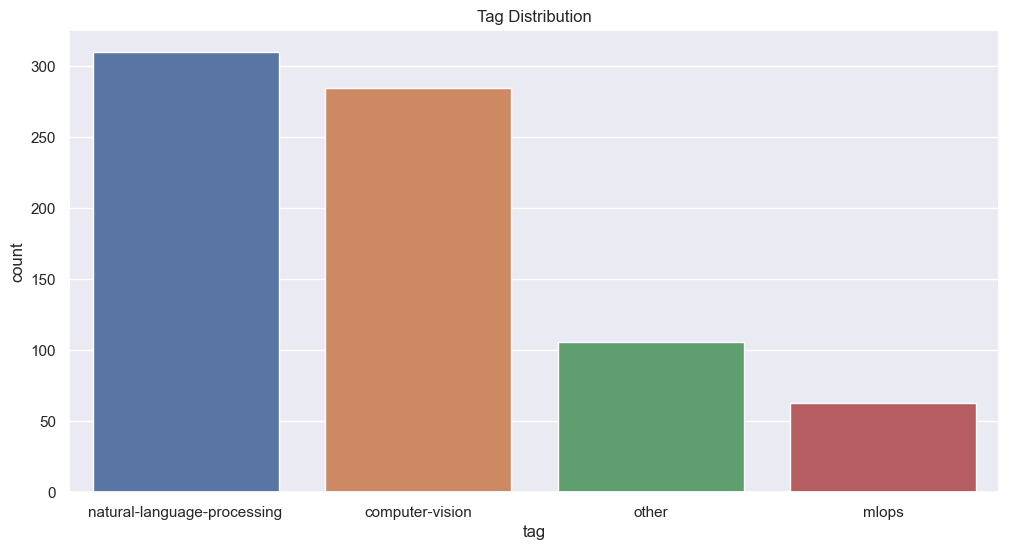

In [12]:
# plot tag distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='tag', order=df['tag'].value_counts().index)
plt.title('Tag Distribution')
plt.xticks()
plt.show()


In [13]:
# Most frequent tokens for each tag 
def show_wordcloud(tag):
    text = " ".join(df[df["tag"] == tag]["title"].astype(str) + " " +
                    df[df["tag"] == tag]["description"].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color="black", mode="RGB").generate(text)
    
    fig, ax = plt.subplots(figsize=(10, 5), facecolor="black")
    ax.imshow(wc, interpolation="bilinear")
    ax.set_facecolor("black")  # Axes background
    ax.axis("off")
    ax.set_title(f"Word Cloud for tag: {tag}", fontsize=16, color="white")
    
    # Force black canvas when saving or rendering
    fig.patch.set_facecolor("black")
    plt.tight_layout(pad=0)
    plt.show()

# Create dropdown with unique tags
tags = df["tag"].unique()
interact(show_wordcloud, tag=Dropdown(options=tags, description="Select Tag:"))

interactive(children=(Dropdown(description='Select Tag:', options=('computer-vision', 'other', 'natural-langua…

<function __main__.show_wordcloud(tag)>

## ✨ Data Preprocessing

### Feature Engineering

In [14]:
# combine title and description
df['text'] = (df["title"] + " " + df["description"])

### Cleaning

In [16]:
# Download NLTK stopwords
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# text cleaning
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [18]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [19]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label Encoding

In [20]:
#  Convert column to categorical
df['tag'] = df['tag'].astype('category')

#  Save the mapping
index_to_class = dict(enumerate(df['tag'].cat.categories))
class_to_index = {v: k for k, v in index_to_class.items()}

print("Class_to_index:", class_to_index)
print("Index to class:", index_to_class)

#  Replace column with codes
df['tag'] = df['tag'].cat.codes

# Decode function
def decode(indices, index_to_class=index_to_class):
    """Convert numeric predictions back to class labels."""
    return [index_to_class[i] for i in indices]

Class_to_index: {'computer-vision': 0, 'mlops': 1, 'natural-language-processing': 2, 'other': 3}
Index to class: {0: 'computer-vision', 1: 'mlops', 2: 'natural-language-processing', 3: 'other'}


In [21]:
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,0
1,show infer tell contextual inference creative ...,0
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [22]:
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer


In [23]:
# Bert tokenizer
Tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

# Tokenize batches of data
def tokenize(batch):
    tokenizer = Tokenizer
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [24]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0], dtype=int8)}

Combine preprocessing into one function

In [25]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [26]:
# Apply
preprocess(df=train_df, class_to_index= class_to_index)

{'ids': array([[  102,  6828,  1630, ...,     0,     0,     0],
        [  102,  2570,  7885, ...,     0,     0,     0],
        [  102,  8854,  2998, ...,     0,     0,     0],
        ...,
        [  102,  3526,   318, ...,     0,     0,     0],
        [  102,  1387, 30110, ...,     0,     0,     0],
        [  102, 10850,   142, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([2, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 2, 0, 3, 3, 0, 1, 0, 3, 2, 0, 0,
        2, 1, 3, 1, 2, 2, 0, 2, 3, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0,
        3, 0, 2, 3, 1, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 0,
        2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 3, 2, 2, 1, 0, 3, 2, 2, 2,
        0, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 3, 3, 3, 0, 2, 2, 0, 3, 0, 1,
        2, 0, 2, 0, 2, 2, 1, 2, 3

## 🌐 Distributed Preprocessing

Performing data processing but in a distributed manner using Ray.

In [27]:
# setup
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [34]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=42)
ds.take(1)

2025-08-17 01:18:15,353	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2025-08-17 01:18:15,569	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-08-17 01:18:15,624	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-08-17 01:18:15,668	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-17 01:18:15,671	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 653,
  'created_on': datetime.datetime(2020, 4, 28, 16, 20, 29),
  'title': 'Semantic Graphs for Generating Deep Questions',
  'description': 'Deep Question Generation (DQG), which aims to generate complex questions that require reasoning over multiple pieces of information of the input passage. ',
  'tag': 'natural-language-processing'}]

In [ ]:

from src.data import stratify_split